In [1]:
## Imports
import numpy as np
import torch
from tabulate import tabulate
from PIL import Image
import json
from utils.misc.misc import accuracy, accuracy_correct
from utils.scripts.algorithms_text_explanations import *
from utils.models.factory import create_model_and_transforms, get_tokenizer
from utils.misc.visualization import visualization_preprocess
from utils.models.prs_hook import hook_prs_logger
from utils.datasets_constants.imagenet_classes import imagenet_classes
from utils.datasets_constants.cifar_10_classes import cifar_10_classes
from utils.datasets_constants.cub_classes import cub_classes, waterbird_classes
import os
from utils.scripts.algorithms_text_explanations import svd_data_approx
from utils.datasets.dataset_helpers import dataset_to_dataloader
from torch.nn import functional as F
from utils.scripts.algorithms_text_explanations_funcs import *


/home/ggil/anaconda3/envs/MT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ggil/anaconda3/envs/MT/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
## Parameters
device = 'cpu'
pretrained = 'laion2b_s34b_b79k' # 'laion2b_s32b_b79k'
model_name = 'ViT-B-32' # 'ViT-H-14'
seed = 0
num_last_layers = 4
subset_dim = None
tot_samples_per_class = None
dataset_text_name = "top_1500_nouns_5_sentences_imagenet_clean"
datataset_image_name = "binary_waterbirds"
algorithm = "svd_data_approx"
batch_size = 16 # only needed for the nn search
path = './datasets/' # only needed for the nn search

In [3]:
## Loading Model
model, _, preprocess = create_model_and_transforms(model_name, pretrained=pretrained, cache_dir="../cache")
model.to(device)
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size
tokenizer = get_tokenizer(model_name)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Len of res:", len(model.visual.transformer.resblocks))

prs = hook_prs_logger(model, device, spatial=False) # This attach hook to get the residual stream

Using local files


/home/ggil/ETHZ/MT2024/utils/models/factory.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_location)


Model parameters: 151,277,313
Context length: 77
Vocab size: 49408
Len of res: 12


In [7]:
## Run the chosen algorithm on a dataset to derive text explanations 
command = f"python -m utils.scripts.compute_text_explanations --device {device} --model {model_name} --algorithm {algorithm} --seed {seed} --text_per_princ_comp 20 --num_of_last_layers {num_last_layers} --text_descriptions {dataset_text_name}"
!{command}

Number of layers: 12
  0%|                                                     | 0/4 [00:00<?, ?it/s]
Layer [8], Head: 0

Layer [8], Head: 1

Layer [8], Head: 2

Layer [8], Head: 3

Layer [8], Head: 4

Layer [8], Head: 5

Layer [8], Head: 6

Layer [8], Head: 7

Layer [8], Head: 8

Layer [8], Head: 9

Layer [8], Head: 10

Layer [8], Head: 11
 25%|███████████▎                                 | 1/4 [00:02<00:07,  2.64s/it]
Layer [9], Head: 0

Layer [9], Head: 1

Layer [9], Head: 2

Layer [9], Head: 3

Layer [9], Head: 4

Layer [9], Head: 5

Layer [9], Head: 6

Layer [9], Head: 7

Layer [9], Head: 8

Layer [9], Head: 9

Layer [9], Head: 10

Layer [9], Head: 11
 50%|██████████████████████▌                      | 2/4 [00:05<00:06,  3.04s/it]
Layer [10], Head: 0

Layer [10], Head: 1

Layer [10], Head: 2

Layer [10], Head: 3

Layer [10], Head: 4

Layer [10], Head: 5

Layer [10], Head: 6

Layer [10], Head: 7

Layer [10], Head: 8

Layer [10], Head: 9

Layer [10], Head: 10

Layer [10], Head: 11
 

In [4]:
# Load the new created attention datasets
attention_dataset = f"output_dir/{datataset_image_name}_completeness_{dataset_text_name}_{model_name}_algo_{algorithm}_seed_{seed}.jsonl"

# Load necessary data
attns_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_attn_{model_name}_seed_{seed}.npy", mmap_mode="r"))  # [b, l, h, d], attention values
mlps_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_mlp_{model_name}_seed_{seed}.npy", mmap_mode="r"))  # [b, l, h, d], mlp values
classifier_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_classifier_{model_name}.npy", mmap_mode="r"))  # [b, l, h, d], embedding of the labels
labels_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_labels_{model_name}_seed_{seed}.npy", mmap_mode="r")) # Position of the labels in the cosndiered dataset
final_embeddings_images = torch.tensor(np.load(f"output_dir/{datataset_image_name}_embeddings_{model_name}_seed_{seed}.npy", mmap_mode="r"))
final_embeddings_texts = torch.tensor(np.load(f"output_dir/{dataset_text_name}_{model_name}.npy", mmap_mode="r"))
with open( f"utils/text_descriptions/{dataset_text_name}.txt", "r") as f:
    texts_str = np.array([i.replace("\n", "") for i in f.readlines()])
# Get mean ablation
no_heads_attentions_ = attns_.sum(axis=(2))  # Sum over heads dimension
last_ = attns_.shape[1] - num_last_layers
# Replace attention activations until 'last' layer with their average, while keeping later layers intact.
current_mean_ablation_per_head_sum_ = torch.mean(no_heads_attentions_[:, :last_ + 1], axis=0).sum(0)

# Save important stuff
nr_layers_ = attns_.shape[1]
nr_heads_ = attns_.shape[2]

if datataset_image_name == "imagenet":
    ds_ = ImageNet(root=path+"imagenet/", split="val", transform=visualization_preprocess)
elif datataset_image_name == "binary_waterbirds":
    ds_ = BinaryWaterbirds(root=path+"waterbird_complete95_forest2water2/", split="test", transform=visualization_preprocess)
elif datataset_image_name == "CIFAR100":
    ds_ = CIFAR100(
        root=path, download=True, train=False, transform=visualization_preprocess
    )
elif datataset_image_name == "CIFAR10":
    ds_ = CIFAR10(
        root=path, download=True, train=False, transform=visualization_preprocess
    )
else:
    ds_ = ImageFolder(root=path, transform=visualization_preprocess)

classes_ = {
        'imagenet': imagenet_classes, 
        'CIFAR10': cifar_10_classes,
        'waterbirds': cub_classes, 
        'binary_waterbirds': waterbird_classes, 
        'cub': cub_classes}[datataset_image_name]
# Depending
ds_vis_ = dataset_subset(
    ds_,
    samples_per_class=subset_dim,
    tot_samples_per_class=tot_samples_per_class,  # or whatever you prefer
    seed=seed,
)

# Print metadata accuracy if waterbird
if classes_ == waterbird_classes:
    root = "datasets/waterbird_complete95_forest2water2/"
    df = pd.read_csv(root + "metadata.csv")
    filtered_df = df[df['split'] == 2]

    s = [(os.path.join(root, filtered_df.iloc[i]['img_filename']), filtered_df.iloc[i]['y'], filtered_df.iloc[i]['place']) for i in range(len(filtered_df))]
    background_groups_ = list([x[2] for x in s])

Full dataset


# Print the top Principal Components text-interpretation for each Head

In [10]:
data = []
min_princ_comp = 10

# Read JSON lines from attention_dataset
# This file contains data about layers, heads, and their principal components (PCs) with associated metrics.
data = get_data(attention_dataset, -1)
    
# Print the data in a nice formatted table
print_data(data, min_princ_comp)

Layer 8, Head 0, Principal Component 0, Variance 0.120, Relative Variance 5.480, Head Rank 63
+----+-------------------------------------------------------------+---------------------+-----------------------------------------------+---------------------+
|    | Negative                                                    |   Negative_Strength | Positive                                      |   Positive_Strength |
|----+-------------------------------------------------------------+---------------------+-----------------------------------------------+---------------------|
|  0 | An image of a seatbelt fastened in a car.                   |            0.149065 | An image of joyful eyes accompanying a smile. |           -0.120498 |
|  1 | An image of a protective breastplate.                       |            0.146461 | An image of difficulty.                       |           -0.118547 |
|  2 | An image of a carton of milk with a label.                  |            0.146207 | An image o

# Strongest Principal Components per Dataset

In [ ]:
# Number of top entries to retrieve
top_k = 10
min_heap = []

# Retrieve data
data = get_data(attention_dataset, -1, skip_final=True)

# Sort data entries in descending order of strength_abs of the princial component
top_k_entries = top_data(sort_data_by(data, "strength_abs", descending=True), top_k=top_k)

# Print the top_k entries in a nice formatted table
print_used_heads(top_k_entries)
print_data(top_k_entries)


# Visualize singular values of a principal component (both text and images)

In [134]:
# Info on data
layer = 11
head = 11
princ_comp = 0
# Define the number of top and worst images to look at for each princ_comp
nr_top_imgs = 20  # Number of top elements
nr_worst_imgs = 20  # Number of worst elements
nr_cont_imgs = 0  # Length of continuous elements


In [ ]:
## OPT. Visualize textSpan
attention_dataset_ts = f"output_dir/{datataset_image_name}_completeness_{dataset_text_name}_{model_name}_algo_text_span_seed_{seed}.jsonl"

visualize_text_span(layer, head, attention_dataset_ts, top_k= 5)


In [ ]:
visualize_principal_component(layer, head, princ_comp, nr_top_imgs, nr_worst_imgs, nr_cont_imgs, attention_dataset, final_embeddings_images, final_embeddings_texts, seed, path, texts_str, dataset=datataset_image_name, samples_per_class=subset_dim, tot_samples_per_class=tot_samples_per_class)

In [ ]:
# Visualize PCs strength
data = get_data(attention_dataset)
plot_pc_sv(data, layer, head)

# Test accuracy of reconstruction of text and images using only the final embedding and their projections

In [ ]:
# Number of top entries to retrieve
top_k = 5
min_heap = []
image = preprocess(Image.open('images/woman.png'))[np.newaxis, :, :, :]  # Add batch dimension
text_query = "An image of a woman."

# Encode the image
prs.reinit()  # Reinitialize the residual stream hook

# Encode the image with no gradient calculation
with torch.no_grad():
      image_emb = model.encode_image(
        image.to(device),
        attn_method='head_no_spatial',
        normalize=True)

      # Encode the text
      text_query_token = tokenizer(text_query).to(device)  # Tokenize the text query
      topic_emb = model.encode_text(text_query_token, normalize=True)  # Encode the text query

# Retrieve data
data = get_data(attention_dataset, -1, skip_final=True)

# Get mean of data and texts
mean_final_images = torch.mean(final_embeddings_images, axis=0).to(device)
mean_final_texts = torch.mean(final_embeddings_texts, axis=0).to(device)

# Mean center the embeddings
topic_emb -= mean_final_texts
image_emb -= mean_final_images

# Iterate through the attention dataset and reconstruct embeddings
[topic_emb_rec, image_emb_rec], _ = reconstruct_embeddings(data, [topic_emb, image_emb], ["text", "image"], device=device)


# Print norms to understand magnitude before normalization
print("Norm of topic_emb_rec before normalization:", topic_emb_rec.norm().item())
print("Norm of image_emb_rec before normalization:", image_emb_rec.norm().item())

# Normalize the reconstructed embeddings so they lie on the unit sphere
topic_emb_rec /= topic_emb_rec.norm(dim=-1, keepdim=True)
image_emb_rec /= image_emb_rec.norm(dim=-1, keepdim=True)

topic_emb /= topic_emb.norm(dim=-1, keepdim=True)
image_emb /= image_emb.norm(dim=-1, keepdim=True)

# Print similarities between original and reconstructed embeddings
print("Cosine similarity between original topic_emb and reconstructed topic_emb_rec:",
      (topic_emb @ topic_emb_rec.T).item())

print("Cosine similarity between original image_emb and reconstructed image_emb_rec:",
      (image_emb @ image_emb_rec.T).item())

# Print cross-similarities to compare text-image embeddings before and after reconstruction
print("Cosine similarity between original topic_emb and original image_emb:",
      (topic_emb @ image_emb.T).item())

print("Cosine similarity between original topic_emb and reconstructed image_emb_rec:",
      (topic_emb @ image_emb_rec.T).item())

print("Cosine similarity between reconstructed topic_emb_rec and original image_emb:",
      (topic_emb_rec @ image_emb.T).item())

print("Cosine similarity between reconstructed topic_emb_rec and reconstructed image_emb_rec:",
      (topic_emb_rec @ image_emb_rec.T).item())


# Query a topic or image and NNs on that

### Define the query and analyze each Principal Component and derive a strength metric for reconstruction of the query-embedding

In [ ]:
# Set the model to evaluation mode so that no gradients are computed
model.eval()
query_text = True

# Retrieve an embedding
with torch.no_grad():
    if query_text:
        # If querying by text, define a text prompt and encode it into an embedding
        text_query = "An image of a heart"
        # Tokenize the text query and move it to the device (GPU/CPU)
        text_query_token = tokenizer(text_query).to(device)  
        # Encode the tokenized text into a normalized embedding
        topic_emb = model.encode_text(text_query_token, normalize=True)
    else:
        # If querying by image, load and preprocess the image from disk
        prs.reinit()  # Reinitialize any hooks if required
        text_query = "woman.png"
        image_pil = Image.open(f'images/{text_query}')
        image = preprocess(image_pil)[np.newaxis, :, :, :]  # Add batch dimension
        # Encode the image into a normalized embedding
        topic_emb = model.encode_image(
            image.to(device), 
            attn_method='head_no_spatial',
            normalize=True
        )

### Reconstruct embedding and find contributions from principal components
# Retrieve data
data = get_data(attention_dataset, -1, skip_final=True)

# Get mean of data and texts
mean_final_images = torch.mean(final_embeddings_images, axis=0).to(device)
mean_final_texts = torch.mean(final_embeddings_texts, axis=0).to(device)

# Mean center the embeddings
mean_final = mean_final_texts if query_text else mean_final_images

# Mean center the embeddings
topic_emb_cent = topic_emb - mean_final
final_embeddings_texts_cent = final_embeddings_texts.to(device) - mean_final_texts
# Recontruct embedding
[topic_emb_rec_cent], data = reconstruct_embeddings(data, [topic_emb_cent], ["text" if query_text else "image"], return_princ_comp=True, plot=True, means=[mean_final], device=device)

# Normalize the embeddings
topic_emb_rec_cent_norm = topic_emb_rec_cent / topic_emb_rec_cent.norm(dim=-1, keepdim=True)

# The maximum reconstruction score is how close the reconstructed embedding is to the original,
# adjusted by the baseline score. This gives a cosine similarity measure.
topic_emb_cent_norm = topic_emb_cent / topic_emb_cent.norm(dim=-1, keepdim=True)
max_reconstr_score = topic_emb_rec_cent_norm @ topic_emb_cent_norm.T
# Print out the cosine similarity between the original and reconstructed embeddings
print(f"We have a max cosine similarity of: {(max_reconstr_score).item():.4f}")


### Use the strength of the previous reconstruction to derive a good enough reconstruction of the query

In [ ]:
# Extract relevant details from the top-k principal component entries based on the reconstruction of the query
top_k = 25  # Maximum number of top entries to retrieve
approx = 1.1  # Target approximation threshold for the reconstruction quality

# Initialize a tensor to accumulate the reconstructed topic embedding from selected principal components
topic_emb_rec_act = torch.zeros_like(topic_emb)

### Extract relevant details from the top k entries
data = sort_data_by(data, "correlation_princ_comp_abs", descending=True) 

top_k_entries = top_data(data, top_k)

top_k_details = reconstruct_top_embedding(top_k_entries, topic_emb_cent, mean_final, "text" if query_text else "image", max_reconstr_score, top_k, approx, device=device)
# Convert the collected principal component details into a DataFrame for easy processing
print(f"Currently querying the topic: {text_query}")
print_data(top_k_details, is_corr_present=True)

### Prepare scores of images and texts 

In [ ]:
## For Reconstructed Embedding
# Visualize ds
# Initialize arrays to store the top and lowest scores based on similarity with original query
scores_array_images = np.empty(
    final_embeddings_images.shape[0], 
    dtype=[('score', 'f4'), ('score_vis', 'f4'), ('img_index', 'i4')]
)

# Initialize arrays to store the top and lowest scores based on similarity with self reconstructed query
scores_array_images_self = np.empty(
    final_embeddings_images.shape[0], 
    dtype=[('score', 'f4'), ('score_vis', 'f4'), ('img_index', 'i4')]
)

# Create arrays of indexes for referencing images and texts.
indexes_images = np.arange(0, final_embeddings_images.shape[0], 1) 

# Get mean of data and texts
mean_final_images = torch.mean(final_embeddings_images, axis=0).to(device)


# Recontruct embedding
images_rec = reconstruct_all_embeddings_mean_ablation_pcs(top_k_entries, mlps_, attns_, final_embeddings_images, nr_layers_, nr_heads_, last_, ratio=-1, ablation=True)


# Compute the similarity scores between the reconstructed embeddings (images or texts) and the original query embedding.
# The dot product gives a similarity measure, which we store in the scores arrays along with the index.
# We do NOT normalize the score.
# Compute scores for images

scores_array_images["score"] = (images_rec @ topic_emb.T).squeeze().cpu().numpy()
scores_array_images_self["score"] = (torch.diag(images_rec @ final_embeddings_images.T)).squeeze().cpu().numpy()

images_rec /= images_rec.norm(dim=-1, keepdim=True)

scores_array_images["score_vis"] = (images_rec @ topic_emb.T).squeeze().cpu().numpy()
scores_array_images_self["score_vis"] = (torch.diag(images_rec @ final_embeddings_images.T)).squeeze().cpu().numpy()

scores_array_images["img_index"] = indexes_images
scores_array_images_self["img_index"] = indexes_images

In [54]:
# For full CLIP Embedding
# Scores array of real CLIP embeddings
scores_array_images_full = np.empty(
    final_embeddings_images.shape[0], 
    dtype=[('score', 'f4'), ('score_vis', 'f4'), ('img_index', 'i4')]
)

# Compute scores for images
images = final_embeddings_images.to(device)
scores_array_images_full["score"] = (images @ topic_emb.T).squeeze().cpu().numpy()

images /= images.norm(dim=-1, keepdim=True)
scores_array_images_full["score_vis"] = (images @ topic_emb.T).squeeze().cpu().numpy()

scores_array_images_full["img_index"] = indexes_images

# Define the number of top and worst images to look at for each princ_comp
nr_top_imgs = 20  # Number of top elements
nr_worst_imgs = 20  # Number of worst elements
nr_cont_imgs = 20  # Length of continuous elements

### Visualize

In [ ]:
# Define the number of top and worst images to look at for each princ_comp
nr_top_imgs = 20  # Number of top elements
nr_worst_imgs = 20  # Number of worst elements
nr_cont_imgs = 0  # Length of continuous elements

dbs = create_dbs(scores_array_images, None, nr_top_imgs, nr_worst_imgs, nr_cont_imgs)
# Hardcoded visualizations
nrs_dbs = [nr_top_imgs, nr_worst_imgs, nr_cont_imgs]
dbs_new = []
for i, db in enumerate(dbs):
    if nrs_dbs[i] == 0:
        continue
    dbs_new.append(db)
visualize_dbs(top_k_details, dbs_new, ds_vis_, texts_str, classes_, text_query)

In [ ]:
# Visualize full Embeddings similarity
dbs = create_dbs(scores_array_images_full, None, nr_top_imgs, nr_worst_imgs, nr_cont_imgs)
dbs_new = []
for i, db in enumerate(dbs):
    if nrs_dbs[i] == 0:
        continue
    dbs_new.append(db)
visualize_dbs(top_k_details, dbs_new, ds_vis_, texts_str, classes_, text_query)

In [ ]:
# Define the number of top and worst images to look at for each princ_comp
dbs = create_dbs(scores_array_images_self, None, nr_top_imgs, nr_worst_imgs, nr_cont_imgs)
dbs_new = []
for i, db in enumerate(dbs):
    if nrs_dbs[i] == 0:
        continue
    dbs_new.append(db)
visualize_dbs(top_k_details, dbs_new, ds_vis_, texts_str, classes_, text_query)

### Opt, visualize using all NOT selected PCs 

In [5]:
# Get other PCs
data = get_data(attention_dataset, -1, skip_final=True)

top_k_other_details = get_remaining_pcs(data, top_k_entries)

# Recontruct embedding

images_rec = reconstruct_all_embeddings_mean_ablation_pcs(top_k_other_details, mlps_, attns_, final_embeddings_images, nr_layers_, nr_heads_, last_, ratio=-1)

# Compute the similarity scores between the reconstructed embeddings (images or texts) and the original query embedding.
# The dot product gives a similarity measure, which we store in the scores arrays along with the index.
# We do NOT normalize the score.
# Compute scores for images

scores_array_images["score"] = (images_rec @ topic_emb.T).squeeze().cpu().numpy()
scores_array_images_self["score"] = (torch.diag(images_rec @ final_embeddings_images.T)).squeeze().cpu().numpy()

images_rec /= images_rec.norm(dim=-1, keepdim=True)

scores_array_images["score_vis"] = (images_rec @ topic_emb.T).squeeze().cpu().numpy()
scores_array_images_self["score_vis"] = (torch.diag(images_rec @ final_embeddings_images.T)).squeeze().cpu().numpy()

scores_array_images["img_index"] = indexes_images
scores_array_images_self["img_index"] = indexes_images


NameError: name 'top_k_entries' is not defined

In [ ]:
dbs = create_dbs(scores_array_images, None, nr_top_imgs, nr_worst_imgs, nr_cont_imgs)
# Hardcoded visualizations
nrs_dbs = [nr_top_imgs, nr_worst_imgs, nr_cont_imgs]
dbs_new = []
for i, db in enumerate(dbs):
    if nrs_dbs[i] == 0:
        continue
    dbs_new.append(db)
visualize_dbs(top_k_details, dbs_new, ds_vis_, texts_str, classes_, text_query)

In [ ]:
# Define the number of top and worst images to look at for each princ_comp
dbs = create_dbs(scores_array_images_self, None, nr_top_imgs, nr_worst_imgs, nr_cont_imgs)
dbs_new = []
for i, db in enumerate(dbs):
    if nrs_dbs[i] == 0:
        continue
    dbs_new.append(db)
visualize_dbs(top_k_details, dbs_new, ds_vis_, texts_str, classes_, text_query)

# Evaluate classification using reconstruction

## Ablation Study

For the approach Mean ablation from layer 12 to 12, the accuracy is: 40.248533%
For the approach Mean ablation from layer 11 to 12, the accuracy is: 28.564032%
For the approach Mean ablation from layer 10 to 12, the accuracy is: 35.536762%
For the approach Mean ablation from layer 9 to 12, the accuracy is: 45.150155%
For the approach Mean ablation from layer 8 to 12, the accuracy is: 44.908526%
For the approach Mean ablation from layer 7 to 12, the accuracy is: 48.947187%
For the approach Mean ablation from layer 6 to 12, the accuracy is: 44.960304%
For the approach Mean ablation from layer 5 to 12, the accuracy is: 41.025198%
For the approach Mean ablation from layer 4 to 12, the accuracy is: 34.967207%
For the approach Mean ablation from layer 3 to 12, the accuracy is: 50.931999%
For the approach Mean ablation from layer 2 to 12, the accuracy is: 54.746289%
For the approach Mean ablation from layer 1 to 12, the accuracy is: 58.543321%


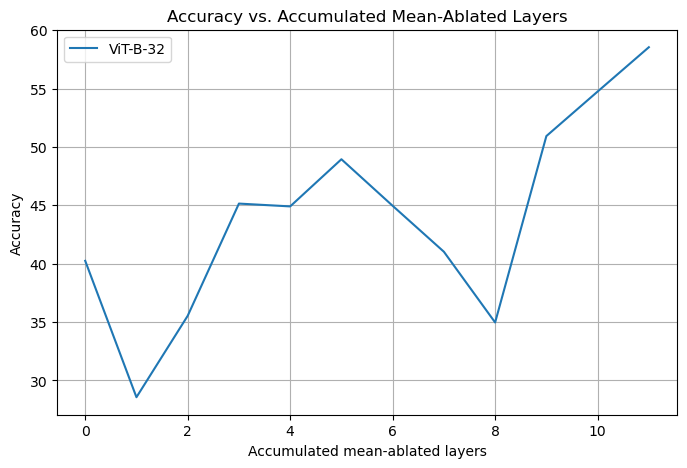

In [11]:
nr_layers = attns_.shape[1]
# Evaluate accuracy using the reconstructed embeddings from the final embedding approach
accs = []
for layer_nr in range(nr_layers):
    current_mean_ablation_per_head_sum = torch.mean(no_heads_attentions_[:, :layer_nr], axis=0).sum(0)
    current_model = (current_mean_ablation_per_head_sum  + no_heads_attentions_[:, layer_nr + 1:].sum(1)) + mlps_.sum(axis=1) 
    acc, _ = test_accuracy(current_model @ classifier_, labels_, label=f"Mean ablation from layer {nr_layers - layer_nr} to {nr_layers}")
    accs.append(acc)

# Create an x-axis that has one increment for each element in acc
x_values = range(len(accs))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_values, accs, linestyle='-', label=model_name)

# Labeling
plt.xlabel("Accumulated mean-ablated layers")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Accumulated Mean-Ablated Layers")

# Add legend for the line
plt.legend()

plt.grid(True)
plt.show()

## Proof of concept 1: Use aggregations of PCs of all labels at once

In [5]:
pcs_per_class = 5
max_pcs_per_head = -1
class_embeddings = classifier_.T  # M x D

# Print baseline accuracy
# Baseline accuracy computation:
baseline = attns_.sum(axis=(1, 2)) + mlps_.sum(axis=1)
acc, idxs = test_accuracy(baseline @ classifier_, labels_, label="Baseline")
output = print_correct_elements(idxs, labels_, classes_)  

if classes_ == waterbird_classes:
    test_waterbird_preds(idxs, labels_, background_groups_)

# Using the knwoledge of which class are we predicting wrongly, give more or less weight to pcs per class
# Reconstruct embeddings for each class label

# Get mean of data and texts
mean_final_images = torch.mean(final_embeddings_images, axis=0)
mean_final_texts = torch.mean(final_embeddings_texts, axis=0)

classes_centered = class_embeddings - mean_final_texts.unsqueeze(0)

# Initialize a (num_images x 2) array to track:
#   [best_score_so_far, class_index_for_that_score]
all_preds = torch.zeros((final_embeddings_images.shape[0], 2), dtype=torch.double)

entries = []
for text_idx in range(classes_centered.shape[0]):
    # Perform query system on entry
    class_i_centered = classes_centered[text_idx, :].unsqueeze(0)

    data = get_data(attention_dataset, max_pcs_per_head, skip_final=True)

    _, data = reconstruct_embeddings(
        data, 
        [class_i_centered], 
        ["text"], 
        return_princ_comp=True, 
        plot=False, 
        means=[mean_final_texts]
    )

    # Extract relevant details from the top k entries
    data_pcs = sort_data_by(data, "correlation_princ_comp_abs", descending=True)
    # Derive nr_pcs_per_class
    top_k_entries = top_data(data_pcs, pcs_per_class)

    print(f"Currently processing label: {classes_[text_idx]} with nr_pcs_per_class:")
    entries += top_k_entries

    top_k_entries = top_data(list(reversed(data_pcs)), pcs_per_class)


# Clean entries from duplicates
entries_set = []
entries_meta = []
for entry in entries:
    layer = entry["layer"]
    head = entry["head"]
    princ_comp = entry["princ_comp"]
    if (layer, head, princ_comp) not in entries_meta:
        entries_meta.append((layer, head, princ_comp))
        entries_set.append(entry)
print(f"Total number of unique entries: {len(entries_set)}")

#data = get_data(attention_dataset, max_pcs_per_head, skip_final=True)
#entries_set = random_pcs(data, pcs_per_class*len(classes_))
# Reconstruct final_embeddings_images
reconstructed_images = reconstruct_all_embeddings_mean_ablation_pcs(
    entries_set,
    mlps_,
    attns_, 
    final_embeddings_images,
    nr_layers_,
    nr_heads_,
    num_last_layers,
    ratio=-1,
)

reconstructed_images /= reconstructed_images.norm(dim=-1, keepdim=True)
predictions = reconstructed_images @ classifier_ #class_embeddings[text_idx, :].T

# Optionally, check accuracy for the current text_idx predictions
acc, idxs = test_accuracy(predictions, labels_, label=f"{classes_[0]}")
print_correct_elements(idxs, labels_, classes_)  
if classes_ == waterbird_classes:
    test_waterbird_preds(idxs, labels_, background_groups_)


For the approach Baseline, the accuracy is: 62.771833%
Number of elements with correct results between the two reconstruction methods: 2981
The correct elements labels are: [('landbird', 1843), ('waterbird', 970)]
Accuracy landbird with landbird background: 88.24833702882484
Accuracy landbird with water background: 30.02217294900222
Accuracy waterbird with land background: 56.54205607476636
Accuracy waterbird with water background: 94.54828660436137
Totoal accuracy landbird: 59.13525498891352
Totoal accuracy waterbird: 75.54517133956386
Total accuracy overall 62.77183293061788
Currently processing label: landbird with nr_pcs_per_class:
Currently processing label: waterbird with nr_pcs_per_class:
Total number of unique entries: 6
Heads to keep:  4
For the approach landbird, the accuracy is: 67.915085%
Number of elements with correct results between the two reconstruction methods: 3759
The correct elements labels are: [('landbird', 1305), ('waterbird', 730)]
Accuracy landbird with landbi

## Proof of concept 2: Remove concepts from the model and use other PCs to reconstruct

In [ ]:
pcs_per_class = 700
max_pcs_per_head = -1
class_embeddings = classifier_.T  # M x D
concepts_to_remove = ["setting", "geolocation"]

# Derive embedding:
for k, concept in enumerate(concepts_to_remove):
    # Retrieve an embedding
    with torch.no_grad():
        # If querying by text, define a text prompt and encode it into an embedding
        # Tokenize the text query and move it to the device (GPU/CPU)
        text_query_token = tokenizer(concept).to(device)  
        # Encode the tokenized text into a normalized embedding
        topic_emb = model.encode_text(text_query_token, normalize=True)
        if k == 0:
            concepts_emb = torch.zeros(len(concepts_to_remove), topic_emb.shape[-1], device=device)
        concepts_emb[k] = topic_emb


# Print baseline accuracy
# Baseline accuracy computation:
baseline = attns_.sum(axis=(1, 2)) + mlps_.sum(axis=1)
acc, idxs = test_accuracy(baseline @ classifier_, labels_, label="Baseline")
if classes_ == waterbird_classes:
    test_waterbird_preds(idxs, labels_, background_groups_)
# Reconstruct embeddings for each class label

# Get mean of data and texts
mean_final_images = torch.mean(final_embeddings_images, axis=0)
mean_final_texts = torch.mean(final_embeddings_texts, axis=0)

concepts_centered = concepts_emb - mean_final_texts.unsqueeze(0)

# Initialize a (num_images x 2) array to track:
#   [best_score_so_far, class_index_for_that_score]
all_preds = torch.zeros((final_embeddings_images.shape[0], 2), dtype=torch.double)

entries = []
for text_idx in range(concepts_centered.shape[0]):
    # Perform query system on entry
    concept_i_centered = concepts_centered[text_idx, :].unsqueeze(0)

    data = get_data(attention_dataset, max_pcs_per_head, skip_final=True)

    _, data_abs = reconstruct_embeddings(
        data, 
        [concept_i_centered], 
        ["text"], 
        return_princ_comp=True, 
        plot=False, 
        means=[mean_final_texts]
    )

    # Extract relevant details from the top k entries
    data_pcs = sort_data_by(data_abs, "correlation_princ_comp_abs", descending=True)
    # Derive nr_pcs_per_class

    top_k_entries = top_data(data_pcs, pcs_per_class)

    print(f"Currently processing label: {concepts_to_remove[text_idx]} with nr_pcs_per_class:")
    entries += top_k_entries

# Clean entries from duplicates
entries_set = []
entries_meta = []
for entry in entries:
    layer = entry["layer"]
    head = entry["head"]
    princ_comp = entry["princ_comp"]
    if (layer, head, princ_comp) not in entries_meta:
        entries_meta.append((layer, head, princ_comp))
        entries_set.append(entry)
print(f"Total number of unique entries: {len(entries_set)}")

# Extract other components
top_k_other_details = get_remaining_pcs(data, entries_set)

#data = get_data(attention_dataset, max_pcs_per_head, skip_final=True)
#top_k_other_details = random_pcs(data, pcs_per_class*len(classes_))
# Reconstruct final_embeddings_images
reconstructed_images = reconstruct_all_embeddings_mean_ablation_pcs(
    top_k_other_details,
    mlps_,
    attns_, 
    final_embeddings_images,
    nr_layers_,
    nr_heads_,
    num_last_layers,
    ratio=-1,
)

reconstructed_images /= reconstructed_images.norm(dim=-1, keepdim=True)
predictions = reconstructed_images @ classifier_ #class_embeddings[text_idx, :].T

# Optionally, check accuracy for the current text_idx predictions
acc, idxs = test_accuracy(predictions, labels_, label=f"{concepts_to_remove[text_idx]}")
print_correct_elements(idxs, labels_, classes_)    
if classes_ == waterbird_classes:
    test_waterbird_preds(idxs, labels_, background_groups_)

For the approach Baseline, the accuracy is: 62.771833%
Accuracy landbird with landbird background: 88.24833702882484
Accuracy landbird with water background: 30.02217294900222
Accuracy waterbird with land background: 56.54205607476636
Accuracy waterbird with water background: 94.54828660436137
Totoal accuracy landbird: 59.13525498891352
Totoal accuracy waterbird: 75.54517133956386
Total accuracy overall 62.77183293061788


## Proof of concept 3: Use as main components of the model what we want

In [ ]:
max_pcs_per_head = -1
class_embeddings = classifier_.T  # M x D
pcs_per_class = [2, 2]
concepts_to_add = ["waterbird", "landbird"]

# Derive embedding:
for k, concept in enumerate(concepts_to_add):
    # Retrieve an embedding
    with torch.no_grad():
        # If querying by text, define a text prompt and encode it into an embedding
        # Tokenize the text query and move it to the device (GPU/CPU)
        text_query_token = tokenizer(concept).to(device)  
        # Encode the tokenized text into a normalized embedding
        topic_emb = model.encode_text(text_query_token, normalize=True)
        if k == 0:
            concepts_emb = torch.zeros(len(concepts_to_add), topic_emb.shape[-1], device=device)
        concepts_emb[k] = topic_emb


# Print baseline accuracy
# Baseline accuracy computation:
baseline = attns_.sum(axis=(1, 2)) + mlps_.sum(axis=1)
acc, idxs = test_accuracy(baseline @ classifier_, labels_, label="Baseline")
if classes_ == waterbird_classes:
    test_waterbird_preds(idxs, labels_, background_groups_)
# Reconstruct embeddings for each class label

# Get mean of data and texts
mean_final_images = torch.mean(final_embeddings_images, axis=0)
mean_final_texts = torch.mean(final_embeddings_texts, axis=0)

concepts_centered = concepts_emb - mean_final_texts.unsqueeze(0)

# Initialize a (num_images x 2) array to track:
#   [best_score_so_far, class_index_for_that_score]
all_preds = torch.zeros((final_embeddings_images.shape[0], 2), dtype=torch.double)

entries = []
for text_idx, pcs_nr in zip(range(concepts_centered.shape[0]), pcs_per_class):
    # Perform query system on entry
    concept_i_centered = concepts_centered[text_idx, :].unsqueeze(0)

    data = get_data(attention_dataset, max_pcs_per_head, skip_final=True)

    _, data_abs = reconstruct_embeddings(
        data, 
        [concept_i_centered], 
        ["text"], 
        return_princ_comp=True, 
        plot=False, 
        means=[mean_final_texts]
    )

    # Extract relevant details from the top k entries
    data_pcs = sort_data_by(data_abs, "correlation_princ_comp_abs", descending=True)
    # Derive nr_pcs_per_class

    top_k_entries = top_data(data_pcs, pcs_nr)

    print(f"Currently processing label: {concepts_to_add[text_idx]} with nr_pcs_per_class:")
    entries += top_k_entries

# Clean entries from duplicates
entries_set = []
entries_meta = []
for entry in entries:
    layer = entry["layer"]
    head = entry["head"]
    princ_comp = entry["princ_comp"]
    if (layer, head, princ_comp) not in entries_meta:
        entries_meta.append((layer, head, princ_comp))
        entries_set.append(entry)
print(f"Total number of unique entries: {len(entries_set)}")

# Reconstruct final_embeddings_images
reconstructed_images = reconstruct_all_embeddings_mean_ablation_pcs(
    entries_set,
    mlps_,
    attns_, 
    final_embeddings_images,
    nr_layers_,
    nr_heads_,
    num_last_layers,
    ratio=-1
)

reconstructed_images /= reconstructed_images.norm(dim=-1, keepdim=True)
predictions = reconstructed_images @ classifier_ #class_embeddings[text_idx, :].T

# Optionally, check accuracy for the current text_idx predictions
acc, idxs = test_accuracy(predictions, labels_, label=f"{concepts_to_add[text_idx]}")
print_correct_elements(idxs, labels_, classes_)    
if classes_ == waterbird_classes:
    test_waterbird_preds(idxs, labels_, background_groups_)

## Proof of concept 4: Compare cosine of reconstruction using PCs of one class vs. all classes

In [ ]:
pcs_per_class = 5
max_pcs_per_head = -1
class_embeddings = classifier_.T  # M x D

# Print baseline accuracy
# Baseline accuracy computation:
baseline = attns_.sum(axis=(1, 2)) + mlps_.sum(axis=1)
acc, idxs = test_accuracy(baseline @ classifier_, labels_, label="Baseline")
if classes_ == waterbird_classes:
    test_waterbird_preds(idxs, labels_, background_groups_)
# Reconstruct embeddings for each class label

# Get mean of data and texts
mean_final_images = torch.mean(final_embeddings_images, axis=0)
mean_final_texts = torch.mean(final_embeddings_texts, axis=0)

classes_centered = class_embeddings - mean_final_texts.unsqueeze(0)

# Initialize a (num_images x 2) array to track:
#   [best_score_so_far, class_index_for_that_score]
all_preds = torch.zeros((final_embeddings_images.shape[0], 2), dtype=torch.double)

for text_idx in range(classes_centered.shape[0]):
    # Perform query system on entry
    class_i_centered = classes_centered[text_idx, :].unsqueeze(0)

    
    data = get_data(attention_dataset, max_pcs_per_head, skip_final=True)

    _, data = reconstruct_embeddings(
        data, 
        [class_i_centered], 
        ["text"], 
        return_princ_comp=True, 
        plot=False, 
        means=[mean_final_texts]
    )

    # Extract relevant details from the top k entries
    data_pcs = sort_data_by(data, "correlation_princ_comp_abs", descending=True)
    top_k_entries = top_data(data_pcs, pcs_per_class)

    # Reconstruct final_embeddings_images
    reconstructed_images = reconstruct_all_embeddings_mean_ablation_pcs(
        top_k_entries,
        mlps_,
        attns_, 
        final_embeddings_images,
        nr_layers_,
        nr_heads_,
        num_last_layers,
        ratio=-1
    )

    reconstructed_images /= reconstructed_images.norm(dim=-1, keepdim=True)
    predictions = reconstructed_images @ class_embeddings[text_idx, :].T #class_embeddings[text_idx, :].T
    # Update "best so far" scores in all_preds
    best_vals_this_round = predictions
    improved_mask = best_vals_this_round > all_preds[:, 0]

    best_idxs_this_round = torch.full_like(all_preds[:, 1], fill_value=text_idx)
    all_preds[improved_mask, 0] = best_vals_this_round[improved_mask].double()
    all_preds[improved_mask, 1] = best_idxs_this_round[improved_mask].double()

    # Optionally, check accuracy for the current text_idx predictions
    acc, idxs = test_accuracy(predictions.unsqueeze(-1), labels_, label=f"{classes_[text_idx]}")
    print_correct_elements(idxs, labels_, classes_)

    # Build a fictitious one-hot matrix from all_preds
    num_images = final_embeddings_images.shape[0]
    num_classes = classifier_.shape[1]  # Typically M x D => M classes => classifier_.shape[1] is #classes

    # Convert the best class index to a LongTensor
    best_class_idxs = all_preds[:, 1].long()

    # Create zero matrix [num_images, num_classes]
    fictitious_preds = torch.zeros((num_images, num_classes), device=best_class_idxs.device)

    # Fill 1.0 in the best predicted class for each image
    fictitious_preds[torch.arange(num_images), best_class_idxs] = 1.0

    # Test accuracy on these "hard" predictions
    acc_best, idxs_best = test_accuracy(fictitious_preds, labels_, label="Best So Far (One-Hot)")
    sorted_output = print_correct_elements(idxs_best, labels_, classes_)
    if classes_ == waterbird_classes:
        test_waterbird_preds(idxs, labels_, background_groups_)

    # Print overall accuracy so far
    tot_sum = 0
    for _, el_nr in sorted_output:
        tot_sum += el_nr
    if subset_dim == None:
        print(f"Tot accuracy so far is {tot_sum/len(labels_)}")

    else:
        print(f"Tot accuracy so far is {tot_sum/((text_idx + 1) * subset_dim)}")    


## Comparison Textspan with waterbird

In [5]:
# Retrive heads textspan
if model_name == "ViT-H-14":
    to_mean_ablate_setting = [
        {"layer": 31, "head": 12},
        {"layer": 30, "head": 11},
        {"layer": 29, "head": 4},
    ]
    to_mean_ablate_geo = [
        {"layer": 31, "head": 8},
        {"layer": 30, "head": 15},
        {"layer": 30, "head": 12},
        {"layer": 30, "head": 6},
        {"layer": 29, "head": 14},
        {"layer": 29, "head": 8},
    ]

elif model_name == "ViT-L-14":
    to_mean_ablate_geo = [
        {"layer": 21, "head": 1},
        {"layer": 22, "head": 12},
        {"layer": 22, "head": 13},
        {"layer": 21, "head": 11},
        {"layer": 21, "head": 14},
        {"layer": 23, "head": 6},
    ]
    to_mean_ablate_setting = [
        {"layer": 21, "head": 3},
        {"layer": 21, "head": 6},
        {"layer": 21, "head": 8},
        {"layer": 21, "head": 13},
        {"layer": 22, "head": 2},
        {"layer": 22, "head": 12},
        {"layer": 22, "head": 15},
        {"layer": 23, "head": 1},
        {"layer": 23, "head": 3},
        {"layer": 23, "head": 5},
    ]

elif model_name == "ViT-B-16":
    to_mean_ablate_setting = [
        {"layer": 11, "head": 3},
        {"layer": 10, "head": 11},
        {"layer": 10, "head": 10},
        {"layer": 9, "head": 8},
        {"layer": 9, "head": 6},
    ]
    to_mean_ablate_geo = [
        {"layer": 11, "head": 6},
        {"layer": 11, "head": 0},
    ]

elif model_name == "ViT-B-32":
    to_mean_ablate_setting = [
        {"layer": 11, "head":5},
        {"layer": 10, "head": 5},
        {"layer": 10, "head": 3},
        {"layer": 9, "head": 1},
    ]
    to_mean_ablate_geo = [
        {"layer": 11, "head": 9},
        {"layer": 11, "head": 5},
    ]
to_mean_ablate_geo_heads = to_mean_ablate_setting + to_mean_ablate_geo
all_heads = [{"layer": l, "head": h} for l in range(nr_layers_ - num_last_layers, nr_layers_) for h in range(nr_heads_)]
for h_1 in to_mean_ablate_geo_heads:
    for c, h_2 in enumerate(all_heads):
        if h_1 == h_2:
            print(c)
            all_heads = all_heads[:c] + all_heads[c+1:]
            break
print(all_heads)
reconstructed_images = reconstruct_all_embeddings_mean_ablation_heads(all_heads, mlps_, attns_, final_embeddings_images,nr_layers_, nr_heads_, num_last_layers)
reconstructed_images /= reconstructed_images.norm(dim=-1, keepdim=True)
predictions = reconstructed_images @ classifier_ #class_embeddings[text_idx, :].T

# Optionally, check accuracy for the current text_idx predictions
acc, idxs = test_accuracy(predictions, labels_, label=f"Textspan")
print_correct_elements(idxs, labels_, classes_)    



41
29
27
13
41
[{'layer': 8, 'head': 0}, {'layer': 8, 'head': 1}, {'layer': 8, 'head': 2}, {'layer': 8, 'head': 3}, {'layer': 8, 'head': 4}, {'layer': 8, 'head': 5}, {'layer': 8, 'head': 6}, {'layer': 8, 'head': 7}, {'layer': 8, 'head': 8}, {'layer': 8, 'head': 9}, {'layer': 8, 'head': 10}, {'layer': 8, 'head': 11}, {'layer': 9, 'head': 0}, {'layer': 9, 'head': 2}, {'layer': 9, 'head': 3}, {'layer': 9, 'head': 4}, {'layer': 9, 'head': 5}, {'layer': 9, 'head': 6}, {'layer': 9, 'head': 7}, {'layer': 9, 'head': 8}, {'layer': 9, 'head': 9}, {'layer': 9, 'head': 10}, {'layer': 9, 'head': 11}, {'layer': 10, 'head': 0}, {'layer': 10, 'head': 1}, {'layer': 10, 'head': 2}, {'layer': 10, 'head': 4}, {'layer': 10, 'head': 6}, {'layer': 10, 'head': 7}, {'layer': 10, 'head': 8}, {'layer': 10, 'head': 9}, {'layer': 10, 'head': 10}, {'layer': 10, 'head': 11}, {'layer': 11, 'head': 0}, {'layer': 11, 'head': 1}, {'layer': 11, 'head': 2}, {'layer': 11, 'head': 3}, {'layer': 11, 'head': 4}, {'layer': 11,

[('landbird', 1808), ('waterbird', 1008)]

## Test different accuracies

In [10]:
# Print shapes of the tensors for debugging purposes:
# attns_: attention activations
# mlps_: MLP activations
# classifier_: classifier weights
# labels_: ground truth labels
print(attns_.shape, mlps_.shape, classifier_.shape, labels_.shape)


# Baseline accuracy computation:
baseline = attns_.sum(axis=(1, 2)) + mlps_.sum(axis=1)
test_accuracy(baseline @ classifier_, labels_, label="Baseline")
mean_final_images = torch.mean(final_embeddings_images, axis=0)
mean_final_texts = torch.mean(final_embeddings_texts, axis=0)

# Test accuracy of mean centered data with mean centered text
mean_centered_data = attns_.sum(axis=(1, 2)) + mlps_.sum(axis=1) - mean_final_images
mean_centered_data /= mean_centered_data.norm(dim=-1, keepdim=True)
mean_centered_classifier_ = classifier_ - mean_final_texts.unsqueeze(-1)
mean_centered_classifier_ /= mean_centered_classifier_.norm(dim=-1, keepdim=True)

test_accuracy(mean_centered_data @ mean_centered_classifier_, labels_, label="Mean centered data with mean centered text")

# Test accuracy of mean centered data with original text
mean_centered_data = attns_.sum(axis=(1, 2)) + mlps_.sum(axis=1) - mean_final_images
mean_centered_data /= mean_centered_data.norm(dim=-1, keepdim=True)
mean_centered_data += mean_final_images
mean_centered_data /= mean_centered_data.norm(dim=-1, keepdim=True)
test_accuracy(mean_centered_data @ classifier_, labels_, label="Mean centered data with original (not mean centered) text")

# We now attempt a "mean ablation" approach for attention
current_model = (current_mean_ablation_per_head_sum_
                 + no_heads_attentions_[:, last_ + 1:].sum(1)) + mlps_.sum(axis=1) 
_, indexes_mean_ablate = test_accuracy(current_model @ classifier_, labels_, label=f"Mean ablation from layer {last_} until layer {attns_.shape[1]}")

# We now attempt a "mean ablation" approach for attention
current_model = (current_mean_ablation_per_head_sum_
                 + no_heads_attentions_[:, last_ + 1:].sum(1)) + mlps_.sum(axis=1) 
current_model -= mean_final_images
current_model /= current_model.norm(dim=-1, keepdim=True)
_, indexes_mean_ablate = test_accuracy(current_model @ classifier_, labels_, label=f"Mean ablation from layer {last_} until layer {attns_.shape[1]} with mean centered images")

torch.Size([5794, 12, 12, 512]) torch.Size([5794, 13, 512]) torch.Size([512, 2]) torch.Size([5794])
For the approach Baseline, the accuracy is: 48.550224%
For the approach Mean centered data with mean centered text, the accuracy is: 47.031412%
For the approach Mean centered data with original (not mean centered) text, the accuracy is: 48.325854%
For the approach Mean ablation from layer 8 until layer 12, the accuracy is: 48.757335%
For the approach Mean ablation from layer 8 until layer 12 with mean centered images, the accuracy is: 47.859855%


## Test different accuracies using reconstructions

In [ ]:
final_embeddings_images_rec_embed = torch.zeros_like(final_embeddings_images)
final_embeddings_images_rec_attns = torch.zeros_like(final_embeddings_images)
final_embeddings_images_rec_attns_not_mean_centered = torch.zeros_like(final_embeddings_images)
image_emb_cent_embed = final_embeddings_images - mean_final_images

final_embeddings_texts_rec_embed = torch.zeros_like(classifier_.T)
texts_emb_cent_embed = (classifier_ - mean_final_texts.unsqueeze(-1)).T

# Open the attention dataset to retrieve projection matrices and mean values
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)
        # If this entry is the final embedding entry (head == -1), skip it.
        if entry["head"] == -1:
            last_line = entry
            continue

        project_matrix = torch.tensor(entry["project_matrix"])
        vh = torch.tensor(entry["vh"])
        # Reconstruct the image embeddings using final embeddings:
        # Center them by subtracting mean attention values, project them through vh, 
        # apply project_matrix and vh again, then add mean values back.
        final_embeddings_images_rec_embed += (image_emb_cent_embed) @ vh.T @ project_matrix @ vh
        final_embeddings_texts_rec_embed += (texts_emb_cent_embed) @ vh.T @ project_matrix @ vh
        # Reconstruct the image embeddings using attention activations:
        # Similar process, but start from attns_ for the given layer/head.
        image_emb_cent_attns = attns_[:, entry["layer"], entry["head"], :] - torch.tensor(entry["mean_values_att"])
        final_embeddings_images_rec_attns += (image_emb_cent_attns) @ vh.T @ project_matrix @ vh + torch.tensor(entry["mean_values_att"])
        final_embeddings_images_rec_attns_not_mean_centered += (image_emb_cent_attns) @ vh.T @ project_matrix @ vh

final_embeddings_images_rec_embed_norm = final_embeddings_images_rec_embed/final_embeddings_images_rec_embed.norm(dim=-1, keepdim=True)

final_embeddings_texts_rec_embed_norm = final_embeddings_texts_rec_embed/final_embeddings_texts_rec_embed.norm(dim=-1, keepdim=True)

final_embeddings_images_rec_attns_not_mean_centered_norm = final_embeddings_images_rec_attns_not_mean_centered/final_embeddings_images_rec_attns_not_mean_centered.norm(dim=-1, keepdim=True)

texts_emb_cent_embed /= texts_emb_cent_embed.norm(dim=-1, keepdim=True)
# Evaluate accuracy using the reconstructed embeddings from the final embedding approach
current_model = final_embeddings_images_rec_embed_norm + mean_final_images
_, indexes_approx_final = test_accuracy(current_model @ classifier_, labels_, label=f"Approximation with final embeddings on only the last layers")

current_model = mlps_.sum(axis=1) + current_mean_ablation_per_head_sum_ + final_embeddings_images_rec_attns_not_mean_centered
_, indexes_approx_activ_only = test_accuracy(current_model @ classifier_, labels_, label=f"Approximation of images with direct contribution of activation space")

# Evaluate accuracy using the reconstructed embeddings from the attention activations approach
current_model = (mlps_.sum(axis=1) + current_mean_ablation_per_head_sum_ + final_embeddings_images_rec_attns)
_, indexes_approx_activ = test_accuracy(current_model @ classifier_, labels_, label=f"Approximation with attention activations")


# Evaluate accuracy using the reconstructed embeddings from the final embedding approach
current_model = final_embeddings_images_rec_embed+ mean_final_images
_, indexes_approx_final = test_accuracy(current_model @ classifier_, labels_, label=f"Approximation of images without mean-ablation")


# Evaluate accuracy using the reconstructed embeddings from the final embedding approach
current_model = final_embeddings_images_rec_embed+ mean_final_images
_, indexes_approx_final = test_accuracy(current_model @ classifier_, labels_, label=f"Approximation of images and texts without mean-ablation")

# Evaluate accuracy using the reconstructed embeddings from the final embedding approach
current_model = (mlps_.sum(axis=1) + current_mean_ablation_per_head_sum_ + final_embeddings_images_rec_attns)
_, indexes_approx_final = test_accuracy(current_model @ classifier_, labels_, label=f"Original images and approximation of texts without mean-ablation")


## Test Bias Correction

In [ ]:
cache_dir = "../cache"
top_k = 30  # Maximum number of top entries to retrieve
approx = 1.1  # Target approximation threshold for the reconstruction quality
## Run the chosen algorithm on a dataset to derive text explanations 
command = f"python -m utils.scripts.bias_removal_test \
    --device {device} --model {model_name} --pretrained {pretrained} --seed {seed} \
    --subset_dim {subset_dim} --dataset_text {dataset_text_name} --dataset {datataset_image_name} \
    --device {device} --top_k {top_k} --max_approx {approx} --cache_dir {cache_dir}"
!{command}

## Test bias removal and subset model

In [ ]:
# Next, we calculate scores for each principal component (PC) while ignoring query info.
# We do this by reconstructing embeddings from the principal components alone, both from 
# the final embeddings perspective and the attention activations perspective.

final_embeddings_images_rec_embed_topic = torch.zeros_like(final_embeddings_images)
final_embeddings_images_rec_attns_topic = torch.zeros_like(final_embeddings_images)

image_emb_cent_embed = final_embeddings_images - mean_final_images

top_k_other_details = get_remaining_pcs(data, top_k_details)
# Iterate through the top_k entries and reconstruct embeddings
for entry in top_k_details:
    # Reconstruct embeddings focusing on each principal component:
    # 1. Start from the final embeddings, center them, and extract the component of interest.
    vh = torch.tensor(entry["vh"])
    project_matrix = torch.tensor(entry["project_matrix"])
    princ_comp = torch.tensor(entry["princ_comp"])

    projection_image_embed = image_emb_cent_embed @ vh.T
    mask_images_embed = torch.zeros_like(projection_image_embed)
    mask_images_embed[:, princ_comp] = projection_image_embed[:, princ_comp]
    final_embeddings_images_rec_embed_topic += mask_images_embed @ project_matrix @ vh

    # Repeat for attention-based activations:
    mean_values_att = torch.tensor(entry["mean_values_att"])
    image_emb_cent_attns = attns_[:, entry["layer"], entry["head"], :] - mean_values_att
    projection_images_attns = image_emb_cent_attns @ vh.T
    mask_images_attns = torch.zeros_like(projection_images_attns)
    mask_images_attns[:, princ_comp] = projection_images_attns[:, princ_comp]
    final_embeddings_images_rec_attns_topic += mask_images_attns @ project_matrix @ vh

""" # Mean ablate the other components
for entry in top_k_other_details:
    # Reconstruct embeddings focusing on each principal component:
    # 1. Start from the final embeddings, center them, and extract the component of interest.
    vh = torch.tensor(entry["vh"])
    project_matrix = torch.tensor(entry["project_matrix"])
    princ_comp = torch.tensor(entry["princ_comp"])
    mean_values_att = torch.tensor(entry["mean_values_att"]).unsqueeze(0)

    projection_image_embed = mean_values_att @ vh.T
    mask_images_embed = torch.zeros_like(projection_image_embed)
    mask_images_embed[:, princ_comp] = projection_image_embed[:, princ_comp]
    final_embeddings_images_rec_embed_topic += mask_images_embed @ project_matrix @ vh

    # Repeat for attention-based activations:
    image_emb_cent_attns = mean_values_att
    projection_images_attns = image_emb_cent_attns @ vh.T
    mask_images_attns = torch.zeros_like(projection_images_attns)
    mask_images_attns[:, princ_comp] = projection_images_attns[:, princ_comp]
    final_embeddings_images_rec_attns_topic += mask_images_attns @ project_matrix @ vh """

# Compute accuracy using the reconstruction from final embeddings, ignoring the query information.
current_model = final_embeddings_images_rec_embed - final_embeddings_images_rec_embed_topic
_, indexes_approx_final_rem = test_accuracy(current_model @ texts_emb_cent_embed.T, labels_, label=f"Approximation with current topic final embeddings (Bias removal)")
print_diff_elements(indexes_approx_final, indexes_approx_final_rem, subset_dim)

# Compute accuracy using the reconstruction from attention activations, also ignoring the query information.
current_model = final_embeddings_images_rec_attns_not_mean_centered - final_embeddings_images_rec_attns_topic
_, indexs_approx_activ_rem = test_accuracy(current_model @ texts_emb_cent_embed.T, labels_, label=f"Approximation with current topic final embeddings (Bias Removal)")
print_diff_elements(indexes_approx_activ_only, indexs_approx_activ_rem, subset_dim)

# Compute accuracy using the reconstruction from final embeddings, ignoring the query information.
current_model = final_embeddings_images_rec_embed_topic
_, indexes_approx_final_rem = test_accuracy(current_model @ texts_emb_cent_embed.T, labels_, label=f"Approximation with current topic final embeddings (Subset)")
print_correct_elements(indexes_approx_final_rem, labels_, classes_)

# Compute accuracy using the reconstruction from attention activations, also ignoring the query information.
current_model = final_embeddings_images_rec_attns_topic
_, indexs_approx_activ_rem = test_accuracy(current_model @ texts_emb_cent_embed.T, labels_, label=f"Approximation with current topic final embeddings (Subset)")
print_correct_elements(indexs_approx_activ_rem, labels_, classes_)
